In [92]:
import importlib
import utilities as utl
importlib.reload(utl)
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import Pauli, SparsePauliOp, Clifford
import numpy as np
import math
import os
current_dir=os.getcwd()
os.chdir("..")
import max_cut_benchmark as maxcut
importlib.reload(maxcut)
os.chdir(current_dir)

import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from copy import deepcopy
from qiskit.circuit import ParameterVector

import itertools
from qiskit.primitives import StatevectorSampler
from typing import List


BASIS=["cx", "rz", "h"]
SHOTS=500000

def update_pauli(operation: QuantumCircuit, pauli_str):
    '''Update pauli_str with operation.'''
    pauli=Pauli(pauli_str)
    evolved=pauli.evolve(operation, frame="h")
    return(str(evolved))

def get_right_cliff_circ(pauli):
    '''Creates the Clifford circuit that is the right part of the Hamiltonian simulation circuit for
    pauli.'''
    pauli=pauli[::-1] #reverse to match qiskit
    quantum_register=QuantumRegister(len(pauli))   

    pauli_circuit = QuantumCircuit(quantum_register)
    circuit_bracket = QuantumCircuit(quantum_register)
    pauli_idexes = []

    for i in range(len(quantum_register)):
        if pauli[i] == 'I':
            continue
        elif pauli[i] == 'Z':
            pauli_idexes.append(i)
        elif pauli[i] == 'X':
            circuit_bracket.h(quantum_register[i])
            pauli_idexes.append(i)
        elif pauli[i] == 'Y':
            circuit_bracket.u(np.pi/2, np.pi / 2, np.pi / 2, quantum_register[i])
            pauli_idexes.append(i)

    if len(pauli_idexes) != 0:
        # the second CNOTs
        for i in reversed(range(len(pauli_idexes) - 1)):
            pauli_circuit.cx(quantum_register[pauli_idexes[i]],
                    quantum_register[pauli_idexes[i + 1]])
        pauli_circuit.compose(circuit_bracket, inplace=True)

    return pauli_circuit
    

def update_hamiltonians(all_hams):
    '''Pushes the right part of each Hamiltonian simulation circuit through the hamiltonian list. 
    Returns the updated list of Hamiltonians.'''
    flat_all_h=list(itertools.chain(*all_hams))
    end_ops=[]
    lengths=[len(ham) for ham in all_hams] #we will use this to restore the leveling of the lists.
    for idx in range(len(flat_all_h)):
        pauli_str=flat_all_h[idx]
        cliff_circ=get_right_cliff_circ(pauli_str)
        # print("clifford circ", cliff_circ)
        end_ops.append(cliff_circ)
        # print(pauli_str)
        # print(cliff_circ)
        former=flat_all_h[0:idx+1] # don't need to update elements to the left.
        #update the ones to the right.
        latter=[update_pauli(cliff_circ, pauli) for pauli in flat_all_h[idx+1::]]
        flat_all_h=former+latter
        # print(flat_all_h)
    # need to reverse the end_ops because the last layers pushed through should be the left most.
    return [flat_all_h[sum(lengths[:idx]):sum(lengths[:idx])+l:] for idx, l in enumerate(lengths)], end_ops[::-1]

class OptimizedQAOA():
    @staticmethod
    def left_exp_pauli(pauli, quantum_register, t):
        """
        The circuit for the left part of exp(i P t), where P is the Pauli term, 
        t is the parameter.
        :param pauli: the string for the Pauli term: e.g. "XIXY".
        :param quantum_register: QuantumRegister.
        :param t: the parameter t in exp(i P t).
        :return: QuantumCircuit that implements exp(i P t) or 
                control version of it.
        """
        if len(pauli) != len(quantum_register):
            raise Exception("Pauli string doesn't match to the quantum register")

        pauli_circuit = QuantumCircuit(quantum_register)
        circuit_bracket = QuantumCircuit(quantum_register)
        pauli_idexes = []

        for i in range(len(quantum_register)):
            if pauli[i] == 'I':
                continue
            elif pauli[i] == 'Z':
                pauli_idexes.append(i)
            elif pauli[i] == 'X':
                circuit_bracket.h(quantum_register[i])
                pauli_idexes.append(i)
            elif pauli[i] == 'Y':
                circuit_bracket.u(np.pi/2, np.pi / 2, np.pi / 2, quantum_register[i])
                pauli_idexes.append(i)

        pauli_circuit.compose(circuit_bracket, inplace=True)
        OptimizedQAOA.left_exp_all_z(pauli_circuit, quantum_register, pauli_idexes, 2*t)
        return pauli_circuit

    @staticmethod
    def left_exp_all_z(circuit, quantum_register, 
                pauli_idexes, t):
        """
        The implementation of the left part of exp(iZZ..Z t), where Z is 
        the Pauli Z operator, t is a parameter.
        :param circuit: QuantumCircuit.
        :param quantum_register: QuantumRegister.
        :param pauli_idexes: the indexes from quantum_register that 
                            correspond to entries not equal to I: 
                            e.g. if we have XIYZI then the 
                            pauli_idexes = [0,2,3].
        :param t: the parameter t in exp(iZZ..Z t).
        """
            
        # the first CNOTs
        for i in range(len(pauli_idexes) - 1):
            circuit.cx(quantum_register[pauli_idexes[i]],
                    quantum_register[pauli_idexes[i + 1]])
        
        # Rz gate
        circuit.rz(t, quantum_register[pauli_idexes[-1]])
            
    @staticmethod
    def create_qaoa_circ(all_hams, reps, end_ops: List):
        '''Creates the qaoa circuit. The assumption is each Pauli string will not require
        the right half of the Hamiltonian simulation circuit.
        Args: all_hams: list of list of hamiltonians. Typically a pattern of [[cost_h], [mixer_h],...]
            end_ops: list of quantum circuits that should be appended at the end.'''
        betas = ParameterVector("β", reps)
        gammas = ParameterVector("γ", reps)
        num_qubits = len(all_hams[0][0])

        all_hams=[[p[::-1] for p in h] for h in all_hams]
        paired_all_hams=list(zip(all_hams[::2], all_hams[1::2]))
        # print(paired_all_hams)

        quantum_register = QuantumRegister(num_qubits)
        exp_hamiltonian = QuantumCircuit(quantum_register)
        # exp_hamiltonian.u(np.pi/2, 0, np.pi, range(num_qubits))
        exp_hamiltonian.h(range(num_qubits))


        for idx, ham in enumerate(paired_all_hams):
            cost_ham=ham[0]
            mixer_ham=ham[1]
            for pauli in cost_ham:
                exp_hamiltonian.compose(OptimizedQAOA.left_exp_pauli(pauli, quantum_register, 
                                    gammas[idx]), inplace=True)
            for pauli in mixer_ham:
                exp_hamiltonian.compose(OptimizedQAOA.left_exp_pauli(pauli, quantum_register, 
                                    betas[idx]), inplace=True)
            exp_hamiltonian.barrier()
        

        if end_ops:
            end_circ=QuantumCircuit(num_qubits)
            for ops in end_ops:
                # print("ops", ops)
                end_circ.compose(ops,inplace=True)
            # print("end", end_circ)
            clifford=Clifford(end_circ)
            end_circ=clifford.to_circuit() # optimizes clifford
            exp_hamiltonian.compose(end_circ, inplace=True)

        exp_hamiltonian.measure_all()


        return exp_hamiltonian
    
def get_sso(dist1, dist2):
    '''Returns the square of the statistical overlap. 
    dist1 and dist2 are probability distributions.
    dist1: list
    dits2: list'''
    sum=0
    common_keys=dist1.keys() & dist2.keys()

    for key in common_keys:
        sum+=math.sqrt(dist1[key]*dist2[key])
    return sum**2

def sim_job(circ):
    # execute 1 circuit with Sampler V2
    sampler = StatevectorSampler()
    job = sampler.run([circ], shots=SHOTS) 
    pub_result = job.result()[0]
    # print(f" > Result class: {type(pub_result)}")
    return pub_result

# def hamming_weight(pauli):
#     length=len(pauli)
#     return length-pauli.count("I")



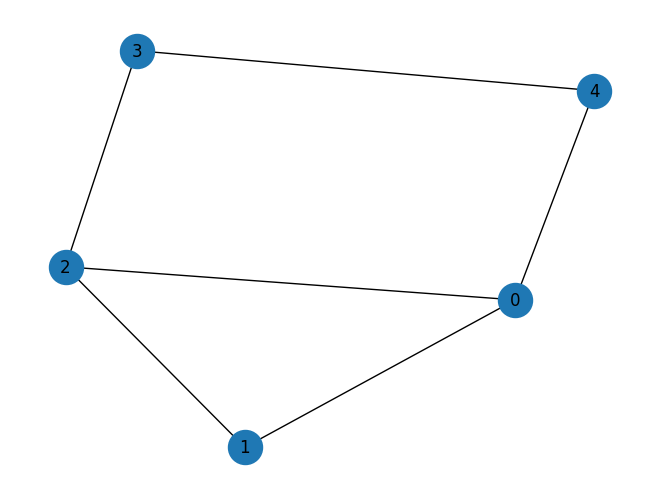

In [93]:
n = 5
totter_number=5 #the number of layers in QAOA.
number_of_edges=n*(n-1)

# graph = rx.PyGraph()
# graph.add_nodes_from(np.arange(0, n, 1))
# edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
# graph.add_edges_from(edge_list)
# draw_graph(graph, node_size=600, with_labels=True)

graph=maxcut.build_graph(n, number_of_edges)

In [94]:
max_cut_paulis = maxcut.build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


[['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'], ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'], ['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'], ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'], ['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'], ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'], ['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'], ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'], ['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'], ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX']]
[['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZZZ', 'ZZZIZ'], ['XIIII', 'ZXIII', 'IIXII', 'IIIXI', 'IZZIX'], ['IXXXX', 'IZIZI', 'IZZZI', 'IIIZI', 'XIZII', 'ZIZII'], ['XXXII', 'ZZIII', 'IIZXX', 'IIIZZ', 'IZZZZ'], ['IXXXI', 'IZIZI', 'IZZZI', 'IIIZI', 'XIZII', 'ZIZII'], ['XXXII', 'ZZIII', 'IIZXI', 'IIIZZ', 'IZZZZ'], ['IXXXI', 'IZIZI', 'IZZZI', 'IIIZI', 'XIZII', 'ZIZII'], ['XXXII', 'ZZIII', 'IIZXI', 'IIIZZ', 'IZZZZ'], ['IXXXI', 'IZIZI', 'IZZZI', 'IIIZI', 'XIZII', 'ZIZII'], ['XXXII', 'ZZII

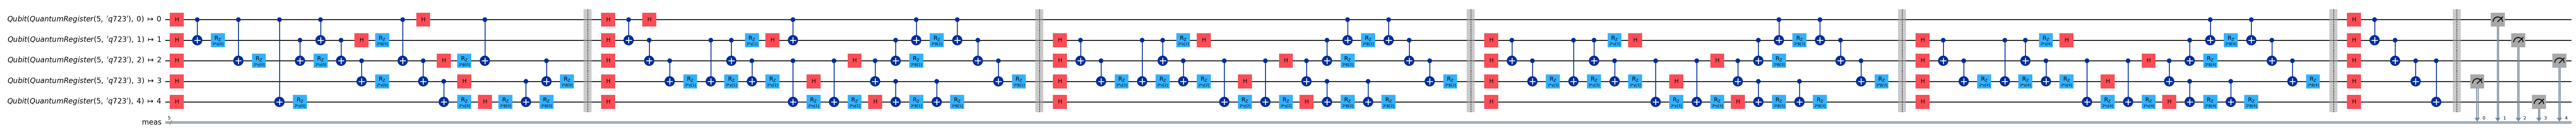

In [95]:
hamiltonians=maxcut.max_cut_pauli_layers(graph, totter_number)
new_hamiltonians, end_ops=update_hamiltonians(hamiltonians)
print(hamiltonians)
print(new_hamiltonians)
print(end_ops)

opt_qaoa_circ=OptimizedQAOA.create_qaoa_circ(new_hamiltonians, totter_number, end_ops)
opt_qaoa_circ=transpile(opt_qaoa_circ, basis_gates=BASIS, optimization_level=3)
opt_qaoa_circ.draw(output="mpl", idle_wires=False, style="iqp", fold=False)


In [96]:
print(opt_qaoa_circ.count_ops())


OrderedDict({'cx': 79, 'rz': 55, 'h': 49, 'barrier': 6, 'measure': 5})


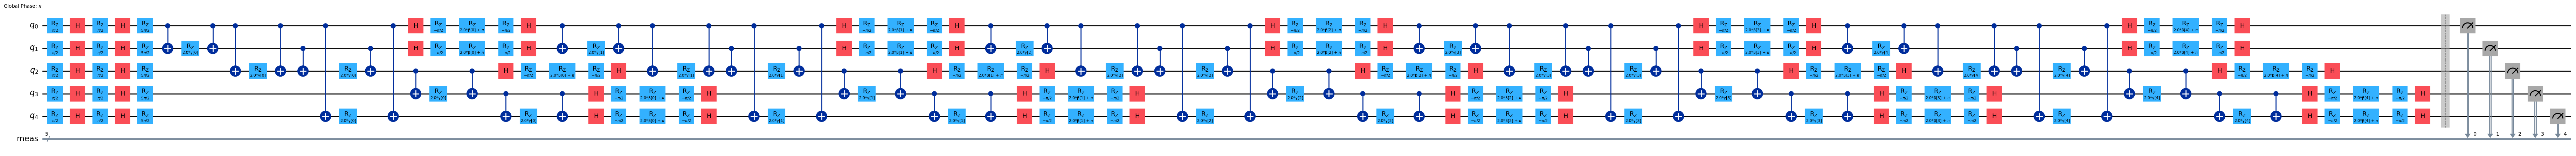

In [97]:
from qiskit.circuit.library import QAOAAnsatz

regular_qaoa_circ = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=totter_number)
regular_qaoa_circ.measure_all()
regular_qaoa_circ=transpile(regular_qaoa_circ.decompose(reps=3), basis_gates=BASIS, optimization_level=3)
regular_qaoa_circ.draw(output="mpl", idle_wires=False, style="iqp", fold=False)


In [98]:
print(regular_qaoa_circ.count_ops())

OrderedDict({'rz': 120, 'h': 60, 'cx': 60, 'measure': 5, 'barrier': 1})


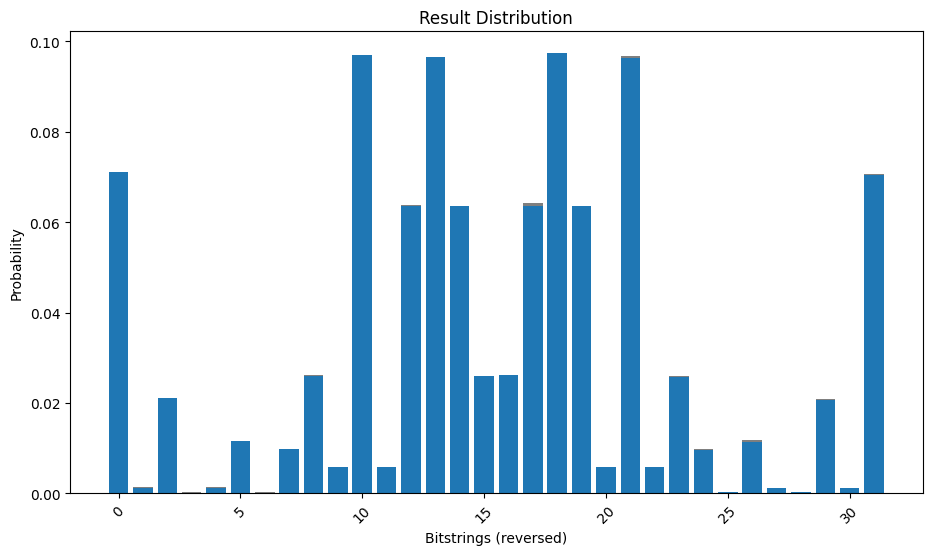

In [99]:
import matplotlib.pyplot as plt
import matplotlib
import random
params= [random.uniform(0, 2*np.pi) for _ in range(2*totter_number)]
# params= [0]*2*totter_number

matplotlib.rcParams.update({"font.size": 10})
dist_reuglar_qaoa=sim_job(regular_qaoa_circ.assign_parameters(params)).data.meas.get_int_counts()
dist_optimized_qaoa=sim_job(opt_qaoa_circ.assign_parameters(params)).data.meas.get_int_counts()
dist_reuglar_qaoa = {key: val/SHOTS for key, val in dist_reuglar_qaoa.items()}
dist_optimized_qaoa = {key: val/SHOTS for key, val in dist_optimized_qaoa.items()}

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(dist_reuglar_qaoa.keys()), list(dist_reuglar_qaoa.values()), color="tab:grey")
ax.bar(list(dist_optimized_qaoa.keys()), list(dist_optimized_qaoa.values()), color="tab:blue")

# for p in positions:
#     ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [100]:
print(get_sso(dist_reuglar_qaoa, dist_optimized_qaoa))

print(f"optimized qaoa: {opt_qaoa_circ.count_ops()}")
print(f"regular: {regular_qaoa_circ.count_ops()}")


# test_circ=QuantumCircuit(2)
# test_circ.cx(0,1)
# test_circ.h(0)
# print(Pauli("IX").evolve(test_circ, frame="h"))

0.9999747786279618
optimized qaoa: OrderedDict({'cx': 79, 'rz': 55, 'h': 49, 'barrier': 6, 'measure': 5})
regular: OrderedDict({'rz': 120, 'h': 60, 'cx': 60, 'measure': 5, 'barrier': 1})
